### Mind the gap

This project aims to identify, measure, and mitigate social biases, such as gender, race, or profession-related stereotypes, in lightweight transformer models through hands-on fine-tuning and evaluation on targeted NLP tasks. More specifically, the project should implement a four-step methodology, defined as follows:

1. Choose a lightweight pre-trained transformer model (e.g., DistilBERT, ALBERT, RoBERTa-base) suitable for local fine-tuning and evaluation.
2. Evaluate the presence and extent of social bias (e.g., gender, racial, or occupational stereotypes) using dedicated benchmark datasets. Both quantitative metrics and qualitative outputs should be evaluated.
3. Apply a bias mitigation technique, such as **fine-tuning on curated counter-stereotypical data**, integrating **adapter layers**, or employing **contrastive learning**, while keeping the solution computationally efficient and transparent.
4. Re-assess the model using the same benchmark(s) to measure improvements. We should compare pre- and post-intervention results, discuss trade-offs (e.g., performance vs. fairness), and visualize the impact of their approach.

#### Dataset
- [StereoSet: Measuring stereotypical bias in pretrained language models](https://github.com/moinnadeem/StereoSet). Nadeem, M., Bethke, A., & Reddy, S. (2020). StereoSet: Measuring stereotypical bias in pretrained language models. *arXiv preprint arXiv:2004.09456*.
- [StereoSet: Measuring stereotypical bias in pretrained language models](https://huggingface.co/datasets/McGill-NLP/stereoset). Hugging Face co.

#### References
- [StereoSet: Measuring stereotypical bias in pretrained language models](https://aclanthology.org/2021.acl-long.416/) 2021.acl-long.416.

In [76]:
import pandas as pd
import numpy as np
from transformers import AutoConfig, AutoTokenizer
from transformers import get_scheduler
from torch.optim import AdamW
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from collections import defaultdict
from tqdm import tqdm
import json
# !pip install spacy textblob
# !python -m textblob.download_corpora
# !python -m spacy download en_core_web_sm
#to output plots within the notebook
%matplotlib inline

import importlib
import inspect
import os
import sys

# %cd /content/
# !ls -R
# repo_name = "MindTheGap"
# #!rm -rf {repo_name}
# if not os.path.exists(repo_name):
#     print(f"Directory {repo_name} does not exist, proceeding with clone.")
#     !git clone https://github.com/Abudo-S/MindTheGap.git

# %cd MindTheGap

import AdaptedMLMTransformer as AdaptedMLMTransformer_Module
import AdaptedNSPTransformer as AdaptedNSPTransformer_Module
import intersentence_loader as intersentence_loader_Module
import SentenceEvaluator as SentenceEvaluator_Module
import ScoreEvaluator as ScoreEvaluator_Module
import SentimentEvaluator as SentimentEvaluator_Module
import dataloader
importlib.reload(AdaptedMLMTransformer_Module) # in case of updates
importlib.reload(AdaptedNSPTransformer_Module) # in case of updates
importlib.reload(intersentence_loader_Module) # in case of updates
importlib.reload(SentenceEvaluator_Module) # in case of updates
importlib.reload(ScoreEvaluator_Module) # in case of updates
importlib.reload(SentimentEvaluator_Module) # in case of updates
importlib.reload(dataloader) # in case of updates
from AdaptedMLMTransformer import AdaptedMLMTransformer
from AdaptedNSPTransformer import AdaptedNSPTransformer
from intersentence_loader import IntersentenceDataset
from SentenceEvaluator import SentenceEvaluator
from ScoreEvaluator import ScoreEvaluator
from SentimentEvaluator import SentimentEvaluator

### General Observations:
- The given dataset contains 2123 intersentence contexts and 2106 intrasentence contexts, each context has 3 sentences that are labeled as ```stereotype, anti-stereotype and unrelated``` with respect to the target bias type.
- Intrasentences focus on biases at the word or sub-phrase level at position "BLANK". Meanwhile intersentences focus on biases within the relationship between the context and its associated sentences.


#### Tasks:
- Intrasentences are considered as a masked-language-modeling (MLM) task in which the model is given a sentence where a certain percentage of the tokens have been replaced with a special [MASK] token. The model's task is to predict the original words/sub-words of the masked tokens based on the surrounding context.
- Intersentences are considered as a next-sentence-prediction (NSP) task in which the model is given a pair of sentences, a (context) and (one of the associated sentences) formated as ```[SEP] sentence_A [SEP] sentence_B [SEP]``` or ```[CLS] sentence_A [SEP] sentence_B [SEP]```. Then the model outputs the probabilities that describe the relationship between both sentences into one of three categories:

    * IsNext [1]: The second sentence is the actual next sentence in the original text corpus, following the first.

    * NotNext [0]: The second sentence is unrelated to the first.

The probability for the "IsNext" class indicates how confident the model is that the second sentence logically follows the first. In our case we can use the probability of "IsNext" to compare the conjunction between each associated labeled sentence with the main context.

## Data Preprocessing
- Intrasentences: The dataloader creates a sentence for each target token of the masked word/subword that replaces "BLANK" with respect to the target word, concatenating the original context.

- Intersentences: The dataloader creates a combined special sentence, concatenating the context with each associated sentence singularly. The generated sentence depends on the used tokenizer, some tokenizers use [CLS] and [SEP], others use only [SEP]. So it's necessary to use a compatible tokenzier with the pre-trained model.


## Context's Sentences Evaluation
- Intrasentences: The MLM model should predict the masked token in each sentence, calculating per each context the mean score of target tokens w.r.t. model's vocabulary. So our task isn't retrieving the highest score belonging to a random predicted word, but retrieving the score of our target word's tokens. Later the score belonging to each sentence is compared to the scores of other sentences belonging to the same context, in order to determine model's preference w.r.t. the target bias.

- Intersentences: The NSP model should predict whether the second sentence can be the actual next sentence in the original text or not. So our task is to retrieve the score that describes the probability of the second sentence to follow the first sentence.




## Labelling and Loss Calculation
Applying Mean Squared Error (MSE) loss with the following target labels in case of different tasks.
$$MSE = \frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y}_i)^2$$

In **sec.6.3** of the original paper, the `IdealLM` is a model as the one that
always picks correct associations for a given target term context. It also picks **equal** number of stereo- typical and anti-stereotypical associations over all the target terms. So the resulting lms, ss and icat scores are 100, 50 and 100 respectively.  

So w.r.t. the aforementioned concept of the `IdealLM`, we may apply the following assumptions for sentence labelling:
- Intrasentences: The loss is calculated by taking average loss between the output tokens' probabilities and different token-score thresholds based on sentence's label:  
    * Stereotypical sentences: w'd consider a threshold = **0.50*** for stereotypical sentences since they're relevant and need to be balanced with the anti-stereotypical ones.
    * Anti-stereotypical sentences: w'd consider a threshold = **0.50*** for stereotypical sentences since they're relevant and need to be balanced with the stereotypical ones.  
    If we need to give a preference for anti-stereotypical sentences by maximizing their labels, the maximum value of the softMax function (theoretically 1 but since the softmax never outputs 1 in practical evaluation, so we decided to set a very small threshold = 0.999 for anti-stereotyped sentences).
    * Unrelated sentences: the minmum value of the softMax function (theoretically 0 but since the softmax never outputs zero in practical evaluation, so we decided to set a very small threshold = **1e-5** for stereotyped sentences), so w'd consider a threshold = **1e-5*** for unrelated sentences since they're irrelevant to the main context.

- Intersentences: The loss is calculated by comparing the predict score of the second sentence (nextScore) and the pre-determined thresholds based on sentence's labels:  
    * Stereotypical sentences: Since we'd like to balance the prediction scores of stereotyped sentences (sentences labeled as "stereotype"); we can label them with **0.50**, so when the model gives a biased score for a stereotyped sentence as a next sentence (nextScore > 0.50 in case of sentimentLM), we still need to **minimize** that score through an optimization process.
    * Anti-stereotypical sentences: also for anti-stereotyped sentences; we can label them with **0.50**, so when the model gives a biased reasonable score for an anti-stereotyped sentence as a next sentence (nextScore < 0.50 in case of sentimentLM), we still need to **maximize** that score through an optimization procedure.  
    * Unrelated sentences: Meanwhile for unrelated sentences; we can label them with **1e-5** (for the same reason in case of unrelated intrasentences), so if the model gives a score for an unrelated sentence as a next sentence (nextScore > 0.0), we'd need to minimize the score w.r.t. the threshold of unrelated sentences (nextScore = 0.0).

In **sec.6.3** of the original paper, `SentimentLM` that for a given a pair of
context associations, the model always pick the as-
sociation with the most negative sentiment. Stereotypical instantiations are more frequently associated with negative sentiment.


### Data Split and Model Comparability
- Since the NSP is not supported in different variations of BERT like (DistilBERT, ALBERT, RoBERTa-base) that are automatically loaded using `AutoModelForSequenceClassification`, the classification head is generated with random weights. In other words, these weights need to be adjusted for our downstream task. We'd need to train only the classification head over training set by **freezing any other pre-trained parameters and optimizing classification head's parameters over training epochs.**  
Stereoset dataset is split into training and test subsets, respectivelly with 85% and 15% of the orginal dataset (intersentences and intrasentences). The data split percentages should also be performed on each single bias domain of (gender, race, profession and religion), in order to have a balanced data distribution w.r.t. each single domain to be evaluated per intersentences and intrasentences.
- In order to mantain the comparability between base models and fine-tuned models, the comparision between models (before and after applying bias mitigation techniques) should be done on the same reproducible examples w.r.t. bias domains and task type either in case of training evaluation or in case of test evaluation. The trained NSP classification head should also be re-trained during the process of training for bias mitigation; in order to maintain a coherent evaluation of the used technique for bias mitigation,  since the bias mitigation (ex. adaptation) modifies the hidden states of the base-model affecting the final predictions on which is the classification head was originally trained.

In [ ]:
# original_init = AdaptedMLMTransformer_Module.AdaptedMLMTransformer.__init__

# # Corrected debug_init signature - assuming only model_name is a required parameter
# def debug_init(self, model_name="roberta-base"):
#     print(f"Initializing AdaptedMLMTransformer with model_name: {model_name}")
#     # Pass only the parameters that original_init expects
#     original_init(self, model_name=model_name)
#     print("AdaptedMLMTransformer initialized.")
#     for name, param in self.named_parameters():
#         print(f"Layer: {name}, Device: {param.device}, Dtype: {param.dtype}")

# AdaptedMLMTransformer_Module.AdaptedMLMTransformer.__init__ = debug_init

In [2]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '0'
INPUT_FILE = "data/stereo_dataset.json"
#INPUT_FILE = "/content/MindTheGap/data/stereo_dataset.json"
OUTPUT_FILE_PRETRAINED ="predictions.json"
OUTPUT_FILE_FINETUNED ="predictions.json"
RESULTS_FILE = "results.json"
SENTIMENT_RESULTS_FILE = "sentiment_results.json"
OUTPUT_DIR = "predictions/"
SAVED_MODEL_DIR = "saved_models/"
SAVED_MLM_ADAPTER_DIR = os.path.join(SAVED_MODEL_DIR, "mlm_adapter/")
SAVED_NSP_ADAPTER_DIR = os.path.join(SAVED_MODEL_DIR, "nsp_adapter/")
NSP_LAYER_FILE_SUFFIX = "nsp_classification_layer.pt"
ADAPTED_NSP_LAYER_FILE_SUFFIX = "adapted_nsp_classification_layer.pt"
BATCH_SIZE = 5
MAX_SEQ_LENGTH = 128
TRAINING_SET_SIZE_PERCENT = 0.85
NUM_EPOCHS = 10
LEARNING_RATE = 5e-5 #0.00005

### Train NSP Classification Layer for Intersentences

In [56]:
pretrained_model_name="roberta-base"
nsp_model = AdaptedNSPTransformer(model_name=pretrained_model_name)

nsp_layer_file = f"{nsp_model.model_name}_{NSP_LAYER_FILE_SUFFIX}"
nsp_layer_path = os.path.join(SAVED_MODEL_DIR, nsp_layer_file)
train_nsp_layer = False

#try to load the NSP classification layer if it exists
try:
    nsp_model.load_nsp_layer(target_path=nsp_layer_path)
except AssertionError as e:
    train_nsp_layer = True

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
#train_nsp_layer = True
evaluator = SentenceEvaluator(input_file=INPUT_FILE, model_name=pretrained_model_name, batch_size=BATCH_SIZE)

Loading data/stereo_dataset.json...
Model max position embeddings: 514
Using device: cuda
Using pretrained class: roberta-base
Model max position embeddings: 514
Using device: cuda
Using pretrained class: roberta-base
First element of the [intrasentences] training set: ('088ef0e919eac7ad0ed68ed5115b2095', 438, tensor([[    0,   250,  2968,  9936, 50264, 15222,    14,  1787,   514,     8,
          1123,     4,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1

c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


In [58]:
optimizer = AdamW(nsp_model.model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=NUM_EPOCHS * len(evaluator.inter_train_dataset))

perfermace_records = defaultdict(list)
if train_nsp_layer:
    #Train NSP head of AutoModelForSequenceClassification
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        train_loss = nsp_model.train_epoch(train_dataset=evaluator.inter_train_dataset,
                                           optimizer=optimizer,
                                           lr_scheduler=lr_scheduler,
                                           loss_fn=nn.MSELoss,
                                           batch_size=BATCH_SIZE,
                                           device=evaluator.device)

        #record training and validation loss
        # train_results = evaluator.evaluate_intersentence(targetModel=nsp_model, useTrainingSet=True)
        # train_loss = sum([train_result['loss'] for train_result in train_results]) / len(train_results)
        val_results = evaluator.evaluate_intersentence(targetModel=nsp_model)
        val_loss = sum([val_result['loss'] for val_result in val_results]) / len(val_results)
        print(f"Training Loss: {train_loss}, Validation Loss: {val_loss}")
        perfermace_records['train_loss'].append(train_loss)
        perfermace_records['val_loss'].append(val_loss)

Epoch 1/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


  0%|          | 0/193 [00:00<?, ?it/s]c:\Users\abudo\source\vscode_projects\MindTheGap\SentenceEvaluator.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = self.loss_fn(torch.tensor(outputs[idx, 1].item()), torch.tensor(sentence_label[idx]))
100%|██████████| 193/193 [00:07<00:00, 25.57it/s]


Training Loss: 0.0550470459299963, Validation Loss: 0.05025910725150036
Epoch 2/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.12it/s]


Training Loss: 0.04928448334484328, Validation Loss: 0.04549408631105075
Epoch 3/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.02it/s]


Training Loss: 0.04488079451272426, Validation Loss: 0.039977521264345645
Epoch 4/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.04it/s]


Training Loss: 0.041742616027396505, Validation Loss: 0.03823178432219663
Epoch 5/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.15it/s]


Training Loss: 0.04093065412238227, Validation Loss: 0.034967713364133096
Epoch 6/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.26it/s]


Training Loss: 0.039421045055695554, Validation Loss: 0.032213029508359456
Epoch 7/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.23it/s]


Training Loss: 0.03873491149383654, Validation Loss: 0.031987523709642265
Epoch 8/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.25it/s]


Training Loss: 0.03887335710763731, Validation Loss: 0.03056673313868743
Epoch 9/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.26it/s]


Training Loss: 0.03746961754623649, Validation Loss: 0.03256207336373154
Epoch 10/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.29it/s]

Training Loss: 0.03759774080313684, Validation Loss: 0.02937503737844684


In [60]:
#save NSP classification layer's weights
if train_nsp_layer:
    nsp_model.save_nsp_layer(target_path=nsp_layer_path)

Saved RobertaForSequenceClassification classification layer in saved_models/roberta-base_nsp_classification_layer.pt


### Loss plot (after NSP classification head training)

In [53]:
'''
model_evaluation should contain loss, val_loss, icat, val_icat
'''
def performance_plot(model_evaluation:dict, ignore_icat_plot=False):
    plt.figure(figsize=(16, 6))

    if not ignore_icat_plot:
        plt.subplot(1, 2, 1)

    #plot loss
    plt.plot(model_evaluation['train_loss'])
    plt.plot(model_evaluation['val_loss'])
    plt.ylabel('Loss', size=12)
    plt.xlabel('Epoch', size=12)
    plt.legend(['training', 'validation'])

    #plot icat score
    if not ignore_icat_plot:
        plt.subplot(1, 2, 2)
        plt.plot(model_evaluation['train_icat'])
        plt.plot(model_evaluation['val_icat'])
        plt.ylabel('ICAT', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['training', 'validation'])

    plt.show()


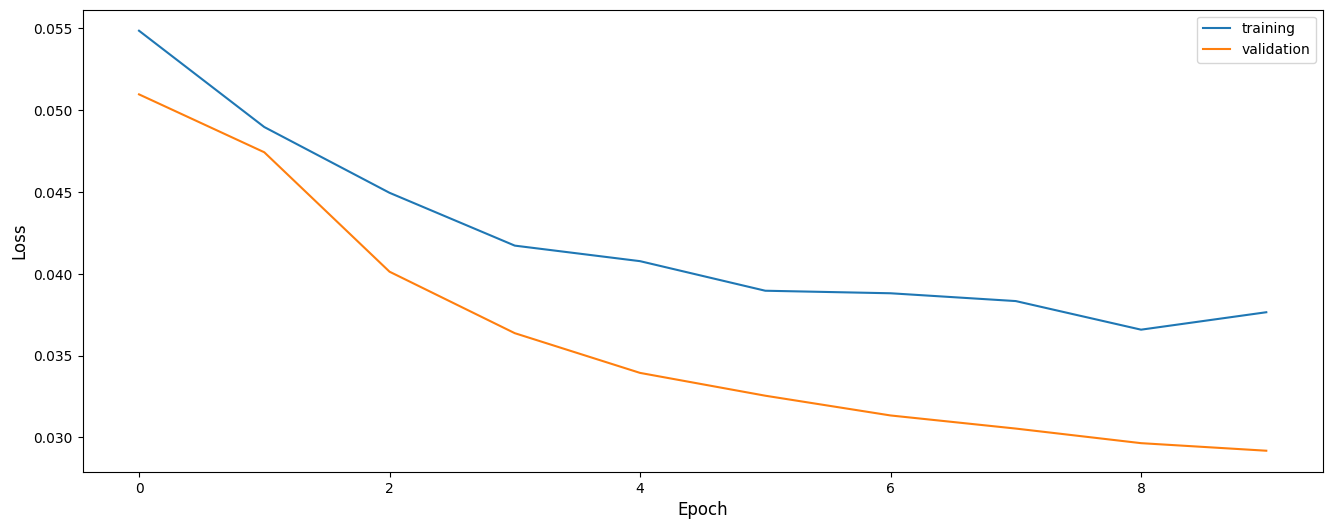

In [ ]:
if train_nsp_layer: #the NSP classification layer has been trained
    performance_plot(perfermace_records, ignore_icat_plot=True)

### Calculate Test Set Predictions (before applying bias mitigation)
Either for intersentences or intrasentences

In [59]:
results = evaluator.evaluate(inter_targetModel=nsp_model)
#print(results)

#save evaluation predictions
output_file = f"{pretrained_model_name}_{OUTPUT_FILE_PRETRAINED}"
output_file = os.path.join(OUTPUT_DIR, output_file)
with open(output_file, "w+") as f:
    json.dump(results, f, indent=2)

Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.26it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:18<00:00, 18.39it/s]


### Bias Evaluation
The paper of ```StereoSet``` considers three main scores in order to evaluate the dataset: the LM Score, SS Score, and ICAT Score, each measures a different aspect of model's performance:

- LM Score (Language Modeling Score)  
  The LM Score is a check that measures a model's ability to distinguish between a semantically comperhensented sentence and a nonsensical, unrelated one. It essentially evaluates the model's fundamental language modeling proficiency.
  $$ LM = \frac{Score(Stereotype)+Score(Anti−stereotype)}{Score(Stereotype)+Score(Anti−stereotype)+Score(Unrelated)} * 100$$

  The ideal LM Score is 100%, which indicates that the model correctly assigns a higher probability to the meaningful sentences (both stereotypical and anti-stereotypical) than to the unrelated sentence.
  If a model has a low LM Score, it means it's a poor language model to begin with, and its SS Score cannot be trusted.

- SS Score (Stereoset Score)  
  The SS Score is a percentage that measures a model's preference for stereotypical over anti-stereotypical associations. A score above 50% indicates a bias towards stereotypes.

  $$ SS ​= \frac{Score(Stereotype)}{Score(Anti−stereotype) + Score(Stereotype)} * 100$$

- ICAT score (Idealized Context Association Test Score)  
  The ICAT Score is the main, composite score (can be considered as **a metric for final evaluation** between models) that combines the LM Score and the SS Score into a single metric. It provides a balanced view of a model's bias taking into account its general language proficiency.
  $$ ICAT = lm ∗ \frac{min(ss, 100 − ss)}{50}$$
  It rewards models that have a high LM Score and an SS Score close to 50%; the optimal SS score = 50% which balances between stereotype and anti-stereotype sentences, exhibiting a neutral model during sentence evaluation.  
  Anti-stereotype sentences are generally preferable than harmful stereotype sentences, but being biased towards anti-stereotype sentences might become unrealistic by over-correcting the model which won't reflect some real-world cases. All in all, the ICAT score aims to reach the neutrality between stereotype and anti-stereotype sentences w.r.t. the language comperhension.


In [61]:
print(f'Overall scores for ({nsp_model.model_name}):')
score_evaluator = ScoreEvaluator(
    gold_file_path=INPUT_FILE, predictions=results)
overall = score_evaluator.get_overall_results()
score_evaluator.pretty_print(overall['overall'])

if os.path.exists(RESULTS_FILE):
    with open(RESULTS_FILE, "r") as f:
        print("Loading already existing results file...")
        d = json.load(f)
else:
    d = {}

#assuming that the file follows a format of {MODELNAME}_predictions.json"
predictions_filename = os.path.basename(output_file)
if "_predictions" in predictions_filename:
    pretrained_class = predictions_filename.split("_")[0]
    d[pretrained_class] = overall
else:
    d = overall

print(f"Saving results to {RESULTS_FILE}...")
with open(RESULTS_FILE, "w+") as f:
    json.dump(d, f, indent=2)

Overall scores for (roberta-base):
Count: 639.0
LM Score: 85.0902754067311
SS Score: 51.70393249507173
ICAT Score: 82.19051370112845
Loss: 0.09388042869221223
Loading already existing results file...
Saving results to results.json...


### Model Plots (before applying bias mitigation)

In [41]:
bias_types = ["gender", "profession", "race", "religion"]
metrics = ["LM Score", "SS Score", "ICAT Score"]

def plot_score_records(intra_data, inter_data, model_name, label_intra="Intrasentence", label_inter="Intersentence"):
    x = range(len(bias_types))
    width = 0.35

    #plot scores
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Score per Task and Bias Type ({model_name})")
    for idx, metric in enumerate(metrics):
        axs[idx].bar([i - width/2 for i in x], intra_data[metric], width, label=label_intra)
        axs[idx].bar([i + width/2 for i in x], inter_data[metric], width, label=label_inter)
        axs[idx].set_xticks(x)
        axs[idx].set_xticklabels([bias_type.capitalize() for bias_type in bias_types], rotation=45)
        axs[idx].set_title(metric)
        axs[idx].legend(title="Task")
        axs[idx].set_ylabel("Score")

    plt.tight_layout()
    plt.show()
    plt.clf()

In [62]:
def plot_loss_scores(intra_loss, inter_loss, model_name, label_intra="Intrasentence", label_inter="Intersentence"):
    x = range(len(bias_types))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar([i - width/2 for i in x], intra_loss, width, label=label_intra)
    plt.bar([i + width/2 for i in x], inter_loss, width, label=label_inter)
    plt.xticks(x, [bias_type.capitalize() for bias_type in bias_types], rotation=45)
    plt.ylabel("Loss")
    plt.title(f"Loss per Task and Bias Type ({model_name})")
    plt.legend(title="Task")
    plt.tight_layout()
    plt.show()
    plt.clf()

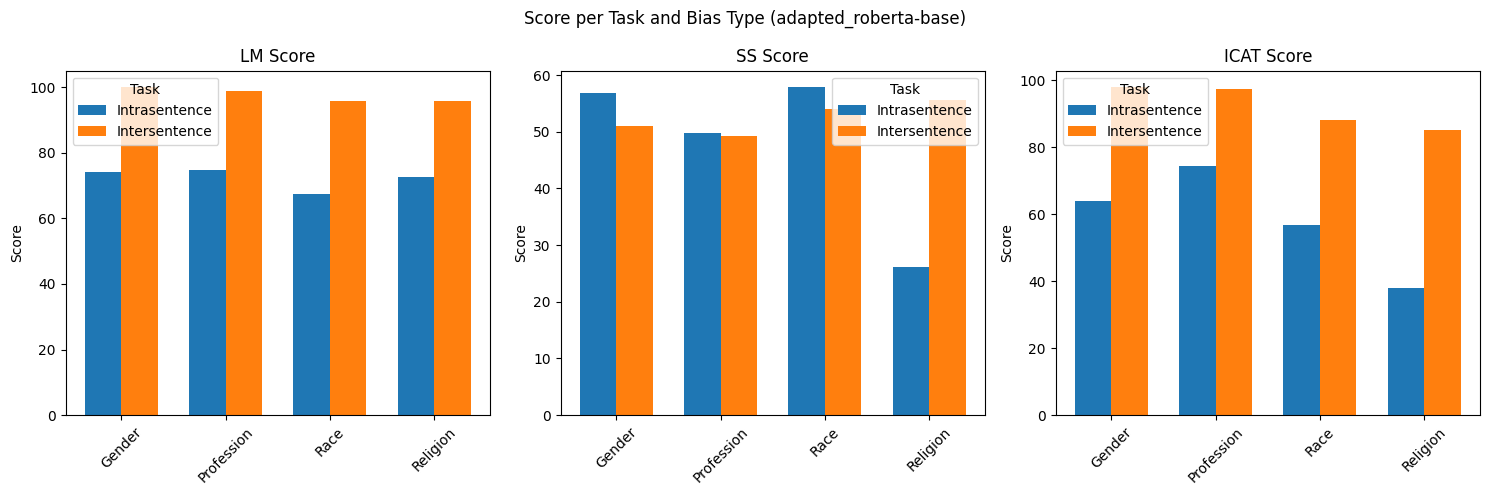

<Figure size 640x480 with 0 Axes>

In [74]:
intra = d["roberta-base"]["intrasentence"]
inter = d["roberta-base"]["intersentence"]

#visualize scores per bias target and task types
intra_data = {metric: [intra[bias][metric] for bias in bias_types] for metric in metrics}
inter_data = {metric: [inter[bias][metric] for bias in bias_types] for metric in metrics}

plot_score_records(intra_data, inter_data, nsp_model.model_name)

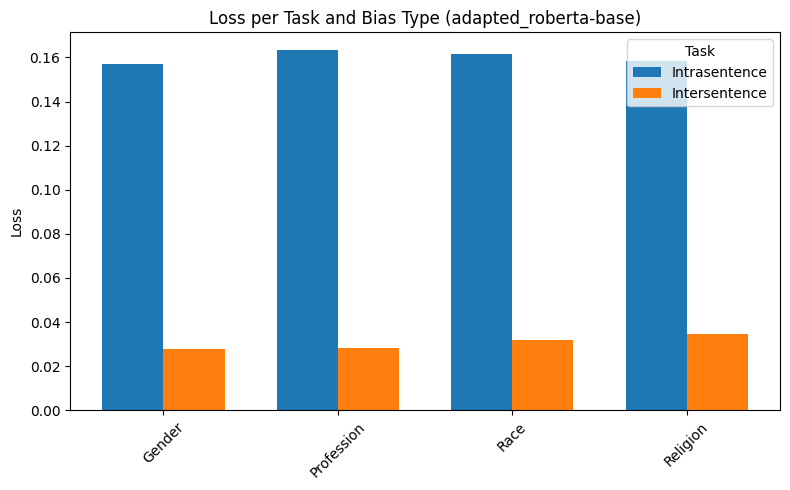

<Figure size 640x480 with 0 Axes>

In [75]:
#visualize loss per bias target and task types
intra_loss = [intra[bias]["Loss"] for bias in bias_types]
inter_loss = [inter[bias]["Loss"] for bias in bias_types]

plot_loss_scores(intra_loss, inter_loss, nsp_model.model_name)

### Qualitative Sentiment Evaluation
Since we have the model predictions of stereotype and anti-stereotype sentences, we'd like to know if the model prediction is based on a specific sentiment score or emotional tone deduced by positive and negative words.
The sentiment analysis of model predictions for each context would help us to know if the model is biased towards benevolent or harmful bias, it can even be neutral between negative or postive contexts.
So we'll compare the model predictions of stereotype and anti-stereotype sentences with the polarity of these sentences in order to know if the model exploits a positive, negative or neutral sentiment in its predictions.
Sentence's polarity exhibits an output within [-1:1]  where:  
  * $\text{Polarity} \gt \epsilon$ : Positive sentiment which indicates the usage of positive words that shows a positive emotion/feeling (Optimal positive sentiment = 1.0).
  * $-\epsilon \leq \text{Polarity} \leq \epsilon$ : Neutral sentiment which indicates the usage of neutral words that shows a neutral emotion/feeling (Optimal neutral sentiment = 0.0).
  * $\text{Polarity} \lt \epsilon$ : Negative sentiment which indicates the usage of positive words that shows a negative emotion/feeling (Optimal negative sentiment = -1).  
  Where $\epsilon$  is a small positive value (< 0.25).

In [77]:
# !pip install spacy textblob
# !python -m textblob.download_corpora
# !python -m spacy download en_core_web_sm

print(f'Overall sentiment results for ({nsp_model.model_name}):')
sentiment_evaluator = SentimentEvaluator(
    gold_file_path=INPUT_FILE, predictions=results)
overall = sentiment_evaluator.get_overall_results()
sentiment_evaluator.pretty_print(overall['overall'])

if os.path.exists(SENTIMENT_RESULTS_FILE):
    with open(SENTIMENT_RESULTS_FILE, "r") as f:
        print("Loading already existing sentiment results file...")
        d = json.load(f)
else:
    d = {}

#assuming that the file follows a format of {MODELNAME}_predictions.json"
predictions_filename = os.path.basename(output_file)
if "_predictions" in predictions_filename:
    pretrained_class = predictions_filename.split("_")[0]
    d[pretrained_class] = overall
else:
    d = overall

print(f"Saving sentiment results to {SENTIMENT_RESULTS_FILE}...")
with open(SENTIMENT_RESULTS_FILE, "w+") as f:
    json.dump(d, f, indent=2)


Overall sentiment results for (adapted_roberta-base):
Count: 639.0
Positive Score: 0.38184663536776214
Negative Score: 0.20344287949921752
Neutral Score: 0.41471048513302033
Loading already existing sentiment results file...
Saving sentiment results to sentiment_results.json...


### Sentiment Measurement Plot (before applying bias mitigation)

In [78]:
measurements = ["Positive Score", "Negative Score", "Neutral Score"]
def plot_sentiment_measurements(sent_measurements, model_name, title_prefix = ""):
    x = range(len(bias_types))
    width = 0.20

    #plot measurements
    plt.figure(figsize=(8, 5))
    plt.bar([i - width for i in x], sent_measurements[measurements[0]], width, label="Positive")
    plt.bar([i for i in x], sent_measurements[measurements[1]], width, label="Negative")
    plt.bar([i + width for i in x], sent_measurements[measurements[2]], width, label="Neutral")
    plt.xticks(x, [bias_type.capitalize() for bias_type in bias_types], rotation=45)
    plt.ylabel("Measurement")
    plt.title(f"{title_prefix} Sentiment Measurement per Bias Type ({model_name})")
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()
    plt.clf()

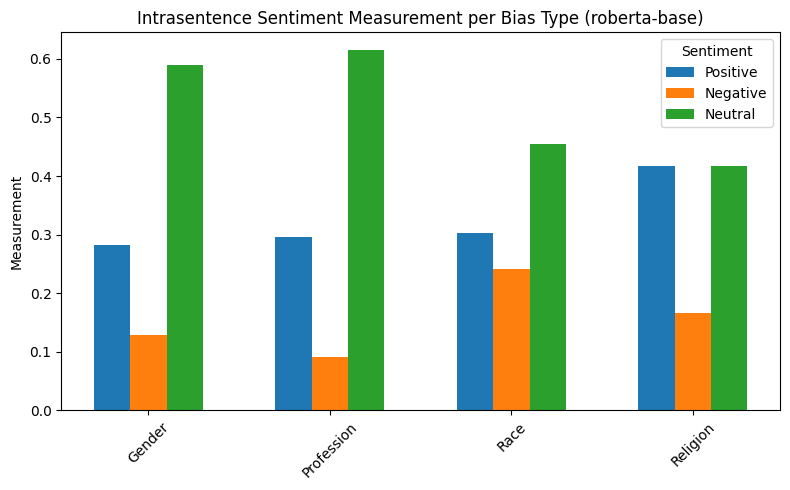

<Figure size 640x480 with 0 Axes>

In [79]:
base_model_sent_intrasentence = {bias: {measure : d[pretrained_model_name]["intrasentence"][bias][measure] for measure in measurements} for bias in bias_types}
bias_sent_measurements = {measure: [base_model_sent_intrasentence[bias][measure] for bias in bias_types] for measure in measurements}
plot_sentiment_measurements(bias_sent_measurements, pretrained_model_name, "Intrasentence")

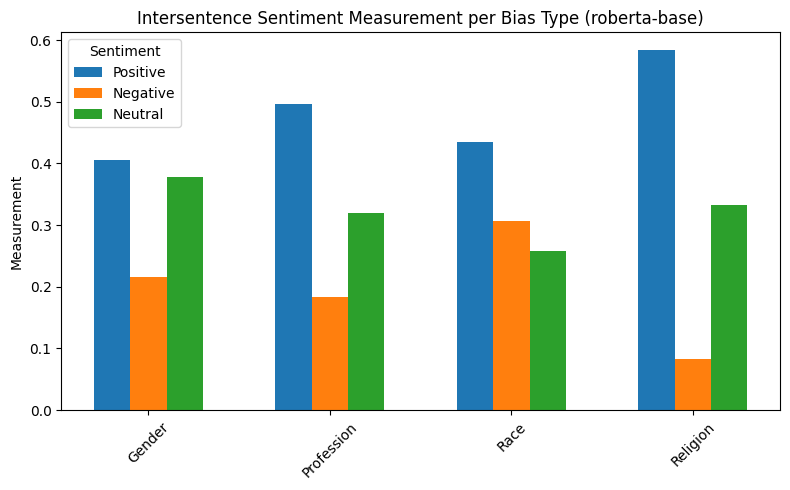

<Figure size 640x480 with 0 Axes>

In [80]:
base_model_sent_intersentence = {bias: {measure : d[pretrained_model_name]["intersentence"][bias][measure] for measure in measurements} for bias in bias_types}
bias_sent_measurements = {measure: [base_model_sent_intersentence[bias][measure] for bias in bias_types] for measure in measurements}
plot_sentiment_measurements(bias_sent_measurements, pretrained_model_name, "Intersentence")

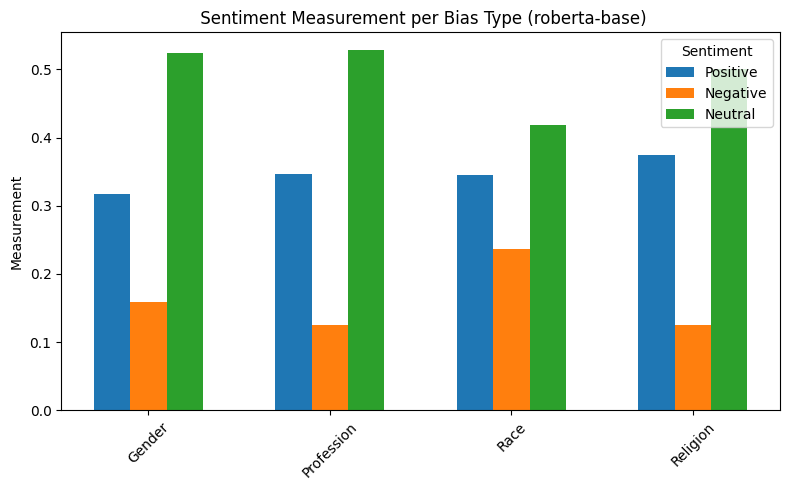

<Figure size 640x480 with 0 Axes>

In [66]:
base_model_sent_overall = {bias: {measure : (d[pretrained_model_name]["intrasentence"][bias][measure] + d[pretrained_model_name]["intersentence"][bias][measure])/2 for measure in measurements} for bias in bias_types}
bias_sent_measurements = {measure: [base_model_sent_overall[bias][measure] for bias in bias_types] for measure in measurements}
plot_sentiment_measurements(bias_sent_measurements, pretrained_model_name)

### Bias Mitigation Strategy
The main goal is to update the model's behavior to balance between anti-stereotypical associations with stereotypical ones, achieving a sort of neutrality within these associations. The LM shouldn't depend on sentiments (especially negative sentiments) to make its predictions. In our experiment we prefer using **adapter layer** over contrastive-learning. Instead of directly modifying the base pre-trained model (which could lead to catastrophic forgetting of its general language skills), the adapter layer acts as a new trainable "sub-model".  
We train only the adapter layer to specifically learn the patterns present in our training dataset. So the core main model knowledge remains frozen, ensuring computational efficiency (lower number of trainable parameters w.r.t. the pre-trained ones) and model (maintaining the original knowledge of the base pre-trained model).

#### LoRA (Low Ranked Adaptation)
LoRA injects trainable low-rank decomposition matrices into the layers of a pre-trained model. For any model layer expressed as a matrix multiplication of the form $h = W_0x$, it performs a reparameterization of target matrices (ex. Q, K and V matrices in the attention layers) without forgetting the inital pretrained parameters, such that:
$$ h = W0x + ∆W x = W_0x + \frac{\alpha} {r} BAx$$
Where B, A are the decomposition trainable matrices, $\alpha$ is the regularization parameter and $r$ is the low-dimensional rank of the decomposition, which is the most important hyperparameter.

* References:  
    - [LoRA: LOW-RANK ADAPTATION OF LARGE LAN-
    GUAGE MODELS](https://arxiv.org/pdf/2106.09685) Hu et al. (2021). .  
    - [Illustration of the LoRA method within one Transformer layer](https://docs.adapterhub.ml/methods.html#lora) AdapterHub.ml.


### What about Constrative Learning?
Contrastive Learning is an approach that works by structuring the training data and ***loss function*** in which the model is trained to minimize the distance between representations of "similar" data points (positives) and maximize the distance between representations of "dissimilar" data points (negatives) in the embedding space.  
The training objective is defined by a Contrastive Loss (ex. Triplet Loss). The loss function penalizes the model when positives are far apart and negatives are close.
A triplet loss function $L(A,P,N)$ in our case can be:
* A: the main context.
* P: positive or anti-stereotypical sentence.
* N: negative, unrelated or stereotypical sentences.

##### CL Efficiency
Since CL is used with full fine-tuning, the entire model's weights must be stored and updated, requiring massive storage, making it computationally difficult to be trained on simple local machines.

### Training Adapted Models

#### Adapted NSP Model

In [88]:
nsp_model = AdaptedNSPTransformer(model_name=pretrained_model_name, use_adapter=True)

nsp_layer_file = f"{pretrained_model_name}_{NSP_LAYER_FILE_SUFFIX}"
nsp_layer_path = os.path.join(SAVED_MODEL_DIR, nsp_layer_file)
train_adapter_layer = False

#load the NSP classification layer
nsp_model.load_nsp_layer(target_path=nsp_layer_path)

if not train_adapter_layer:
    try:
        nsp_model.load_adapter_layer(target_path=SAVED_NSP_ADAPTER_DIR)
    except:
        print("Can't load NSP adapter layer, need to be trained...")
        train_adapter_layer = True

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters in the NSP adapted model:
trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066
Loaded RobertaForSequenceClassification classification layer from saved_models/roberta-base_nsp_classification_layer.pt
Loaded RobertaForSequenceClassification adapter layer from saved_models/nsp_adapter/


c:\Users\abudo\AppData\Local\Programs\Python\Python313\Lib\site-packages\peft\tuners\tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [68]:
optimizer = AdamW(nsp_model.adapted_model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=NUM_EPOCHS * len(evaluator.inter_train_dataset))

perfermace_records = defaultdict(list)
if train_adapter_layer:
    #Train adapter head for AutoModelForSequenceClassification
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        train_loss = nsp_model.train_epoch(train_dataset=evaluator.inter_train_dataset,
                                           optimizer=optimizer,
                                           lr_scheduler=lr_scheduler,
                                           loss_fn=nn.MSELoss,
                                           batch_size=BATCH_SIZE,
                                           device=evaluator.device)

        #record training and validation loss
        train_results = evaluator.evaluate_intersentence(targetModel=nsp_model, useTrainingSet=True)
        # train_loss = sum([train_result['loss'] for train_result in train_results]) / len(train_results)
        val_results = evaluator.evaluate_intersentence(targetModel=nsp_model)
        val_loss = sum([val_result['loss'] for val_result in val_results]) / len(val_results)
        print(f"Training Loss: {train_loss}, Validation Loss: {val_loss}")
        perfermace_records['train_loss'].append(train_loss)
        perfermace_records['val_loss'].append(val_loss)

        score_evaluator = ScoreEvaluator(
            gold_file_path=INPUT_FILE, predictions={"intersentence":train_results})
        train_overall = score_evaluator.get_overall_results()
        score_evaluator = ScoreEvaluator(
            gold_file_path=INPUT_FILE, predictions={"intersentence":val_results})
        val_overall = score_evaluator.get_overall_results()

        perfermace_records['train_icat'].append(train_overall['overall']['ICAT Score'])
        perfermace_records['val_icat'].append(val_overall['overall']['ICAT Score'])

c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


Epoch 1/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


  0%|          | 0/1082 [00:00<?, ?it/s]c:\Users\abudo\source\vscode_projects\MindTheGap\SentenceEvaluator.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = self.loss_fn(torch.tensor(outputs[idx, 1].item()), torch.tensor(sentence_label[idx]))
  0%|          | 3/1082 [00:00<00:42, 25.62it/s]c:\Users\abudo\source\vscode_projects\MindTheGap\SentenceEvaluator.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = self.loss_fn(torch.tensor(outputs[idx, 1].item()), torch.tensor(sentence_label[idx]))
100%|██████████| 1082/1082 [00:42<00:00, 25.22it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.27it/s]

c:\Users\abudo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\abudo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\abudo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\abudo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training Loss: 0.02613690135479066, Validation Loss: 0.010716123776539537
Epoch 2/10
Epoch 2/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1082/1082 [00:42<00:00, 25.22it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.22it/s]



Training Loss: 0.01215495738168189, Validation Loss: 0.005073755911070323
Epoch 3/10
Epoch 3/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1082/1082 [00:43<00:00, 25.13it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.18it/s]



Training Loss: 0.00947697410220673, Validation Loss: 0.004981150131757481
Epoch 4/10
Epoch 4/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1082/1082 [00:42<00:00, 25.20it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.18it/s]



Training Loss: 0.00798177442729597, Validation Loss: 0.00479713012015513
Epoch 5/10
Epoch 5/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1082/1082 [00:42<00:00, 25.17it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.22it/s]



Training Loss: 0.00764119610780497, Validation Loss: 0.005458372833187381
Epoch 6/10
Epoch 6/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1082/1082 [00:42<00:00, 25.21it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.20it/s]



Training Loss: 0.006308412477043305, Validation Loss: 0.004988461252443315
Epoch 7/10
Epoch 7/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1082/1082 [00:42<00:00, 25.20it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.23it/s]



Training Loss: 0.006033303916880958, Validation Loss: 0.004932852194838197
Epoch 8/10
Epoch 8/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1082/1082 [00:42<00:00, 25.20it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.22it/s]



Training Loss: 0.005203698448255129, Validation Loss: 0.004048196597749748
Epoch 9/10
Epoch 9/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1082/1082 [00:42<00:00, 25.22it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.26it/s]



Training Loss: 0.004985040200914604, Validation Loss: 0.0037334074129485497
Epoch 10/10
Epoch 10/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1082/1082 [00:42<00:00, 25.21it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 193/193 [00:07<00:00, 25.30it/s]



Training Loss: 0.004369191428608049, Validation Loss: 0.0042170946376393756


In [69]:
#save adapter layer's weights
if train_adapter_layer:
    nsp_model.save_adapter_layer(target_path=SAVED_NSP_ADAPTER_DIR)

Saved RobertaForSequenceClassification adapter layer in saved_models/nsp_adapter/


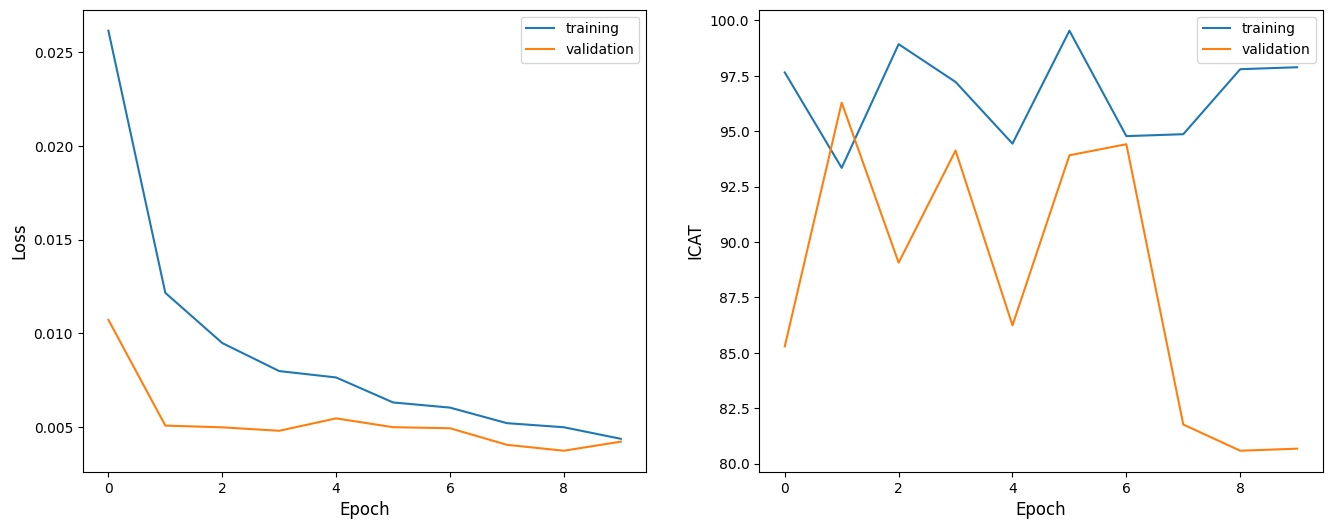

In [70]:
if train_adapter_layer: #the NSP adapter layer has been trained
    performance_plot(perfermace_records, ignore_icat_plot=False)

#### Adapted MLM Model

In [89]:
mlm_model = AdaptedMLMTransformer(model_name=pretrained_model_name, use_adapter=True)
train_adapter_layer = False

if not train_adapter_layer:
    try:
        mlm_model.load_adapter_layer(target_path=SAVED_MLM_ADAPTER_DIR)
    except:
        print("Can't load MLM adapter layer, need to be trained...")
        train_adapter_layer = True

Trainable parameters in the MLM adapted model:
trainable params: 294,912 || all params: 124,992,345 || trainable%: 0.2359
Loaded RobertaForMaskedLM adapter layer from saved_models/mlm_adapter/


In [ ]:
optimizer = AdamW(mlm_model.adapted_model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=NUM_EPOCHS * len(evaluator.intra_train_dataset))

perfermace_records = defaultdict(list)
if train_adapter_layer:
    #Train adapter head for AutoModelForMaskedLM
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        train_loss = mlm_model.train_epoch(train_dataset=evaluator.intra_train_dataset,
                                           optimizer=optimizer,
                                           lr_scheduler=lr_scheduler,
                                           loss_fn=nn.MSELoss,
                                           batch_size=BATCH_SIZE,
                                           device=evaluator.device)

        #record training and validation loss
        train_results = evaluator.evaluate_intrasentence(targetModel=mlm_model, useTrainingSet=True)
        #train_loss = sum([train_result['loss'] for train_result in train_results]) / len(train_results)
        val_results = evaluator.evaluate_intrasentence(targetModel=mlm_model)
        val_loss = sum([val_result['loss'] for val_result in val_results]) / len(val_results)
        print(f"Training Loss: {train_loss}, Validation Loss: {val_loss}")
        perfermace_records['train_loss'].append(train_loss)
        perfermace_records['val_loss'].append(val_loss)

        score_evaluator = ScoreEvaluator(
            gold_file_path=INPUT_FILE, predictions={"intrasentence":train_results})
        train_overall = score_evaluator.get_overall_results()
        score_evaluator = ScoreEvaluator(
            gold_file_path=INPUT_FILE, predictions={"intrasentence":val_results})
        val_overall = score_evaluator.get_overall_results()

        perfermace_records['train_icat'].append(train_overall['overall']['ICAT Score'])
        perfermace_records['val_icat'].append(val_overall['overall']['ICAT Score'])

Epoch 1/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1871/1871 [01:46<00:00, 17.60it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:21<00:00, 15.21it/s]


Training Loss: 0.1526565721558855, Validation Loss: 0.14487982302071958
Epoch 2/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1871/1871 [01:48<00:00, 17.29it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:18<00:00, 18.32it/s]


Training Loss: 0.14153811737765154, Validation Loss: 0.13335657305489484
Epoch 3/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1871/1871 [01:48<00:00, 17.31it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:19<00:00, 17.08it/s]


Training Loss: 0.1359885360299416, Validation Loss: 0.12811517926943802
Epoch 4/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1871/1871 [01:42<00:00, 18.23it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:18<00:00, 18.28it/s]


Training Loss: 0.1330168262015414, Validation Loss: 0.12660291288131842
Epoch 5/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1871/1871 [01:42<00:00, 18.26it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:18<00:00, 18.30it/s]


Training Loss: 0.13147339163754002, Validation Loss: 0.12657855186227918
Epoch 6/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1871/1871 [01:42<00:00, 18.22it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:18<00:00, 18.28it/s]


Training Loss: 0.13030357968661507, Validation Loss: 0.12540817185906794
Epoch 7/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1871/1871 [01:42<00:00, 18.23it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:18<00:00, 18.27it/s]


Training Loss: 0.13038689597275832, Validation Loss: 0.12338060415833985
Epoch 8/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1871/1871 [01:42<00:00, 18.24it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:18<00:00, 18.27it/s]


Training Loss: 0.12889599273554755, Validation Loss: 0.12274056781194864
Epoch 9/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1871/1871 [01:42<00:00, 18.24it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:18<00:00, 18.26it/s]


Training Loss: 0.12785806775965178, Validation Loss: 0.12236019116721837
Epoch 10/10
Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 1871/1871 [01:42<00:00, 18.27it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:18<00:00, 18.28it/s]


Training Loss: 0.12736493646349226, Validation Loss: 0.12237710224264021


In [ ]:
#save adapter layer's weights
if train_adapter_layer:
    mlm_model.save_adapter_layer(target_path=SAVED_MLM_ADAPTER_DIR)

Saved RobertaForMaskedLM adapter layer in saved_models/mlm_adapter/


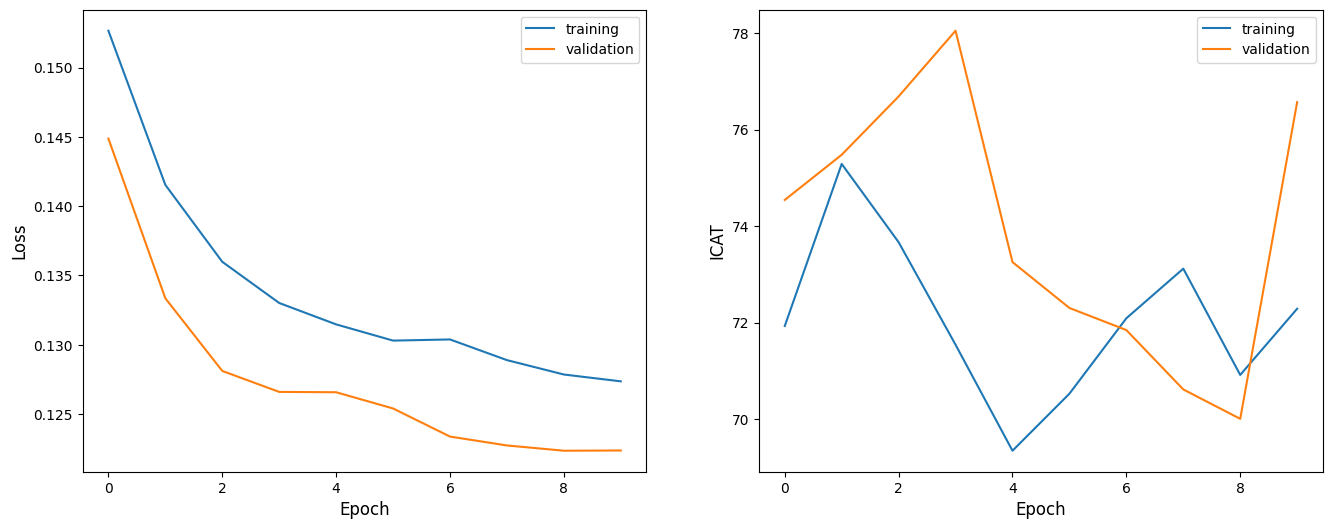

In [ ]:
if train_adapter_layer: #the MLM adapter layer has been trained
    performance_plot(perfermace_records, ignore_icat_plot=False)

### Calculate Test Set Predictions (after applying bias mitigation)
Either for intersentences or intrasentences

In [90]:
results = evaluator.evaluate(intra_targetModel=mlm_model, inter_targetModel=nsp_model)
#print(results)

#save evaluation predictions
output_file = f"{nsp_model.model_name}_{OUTPUT_FILE_PRETRAINED}"
output_file = os.path.join(OUTPUT_DIR, output_file)
with open(output_file, "w+") as f:
    json.dump(results, f, indent=2)

Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


  0%|          | 0/193 [00:00<?, ?it/s]c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)
c:\Users\abudo\source\vscode_projects\MindTheGap\SentenceEvaluator.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = self.loss_fn(torch.tensor(outputs[idx, 1].item())

Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 334/334 [00:17<00:00, 18.63it/s]


### Bias Evaluation of Adapted Pre-trained Model

In [91]:
print(f'Overall scores for ({mlm_model.model_name}):')
score_evaluator = ScoreEvaluator(
    gold_file_path=INPUT_FILE, predictions=results)
overall = score_evaluator.get_overall_results()
score_evaluator.pretty_print(overall['overall'])

#load existing results of any model
if os.path.exists(RESULTS_FILE):
    with open(RESULTS_FILE, "r") as f:
        print("Loading already existing results file...")
        d = json.load(f)
else:
    d = {}

#assuming that the file follows a format of {MODELNAME}_predictions.json"
predictions_filename = os.path.basename(output_file)
if "_predictions" in predictions_filename:
    pretrained_class = predictions_filename.replace("_predictions.json", "")
    d[pretrained_class] = overall
else:
    d = overall

print(f"Saving results to {RESULTS_FILE}...")
with open(RESULTS_FILE, "w+") as f:
    json.dump(d, f, indent=2)

Overall scores for (adapted_roberta-base):
Count: 639.0
LM Score: 94.93924500253614
SS Score: 58.09160249033667
ICAT Score: 79.57503237667204
Loss: 0.062003836912022235
Loading already existing results file...
Saving results to results.json...


### Model Plots (after applying bias mitigation)

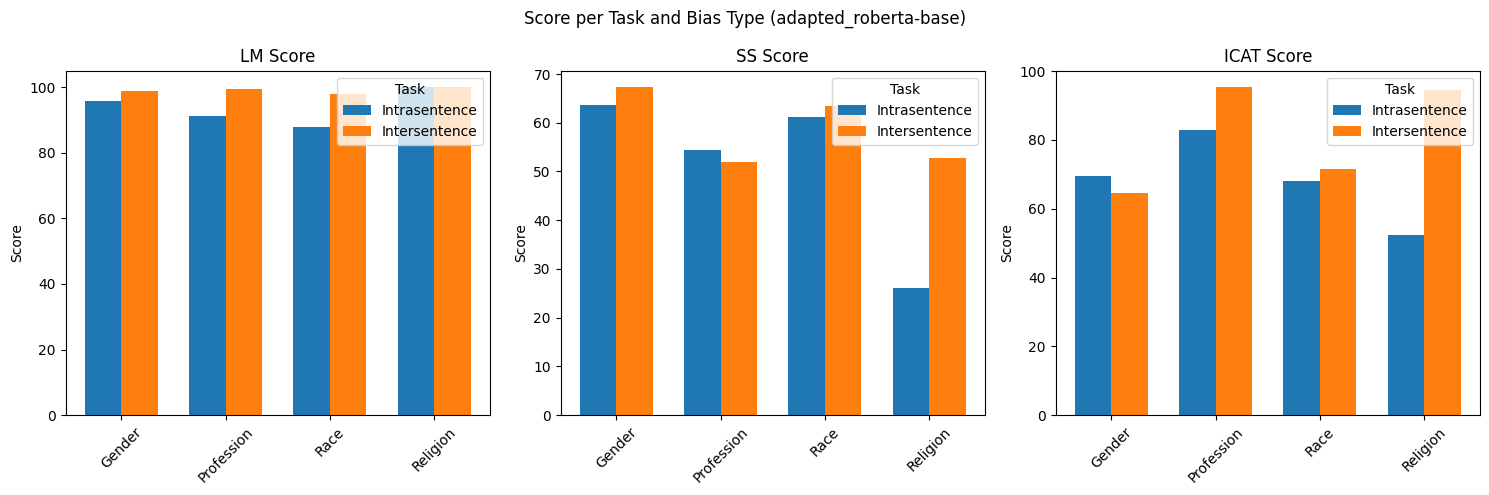

<Figure size 640x480 with 0 Axes>

In [92]:
intra = d[mlm_model.model_name]["intrasentence"]
inter = d[mlm_model.model_name]["intersentence"]

#visualize scores per bias target and task types
intra_data = {metric: [intra[bias][metric] for bias in bias_types] for metric in metrics}
inter_data = {metric: [inter[bias][metric] for bias in bias_types] for metric in metrics}

plot_score_records(intra_data, inter_data, mlm_model.model_name)

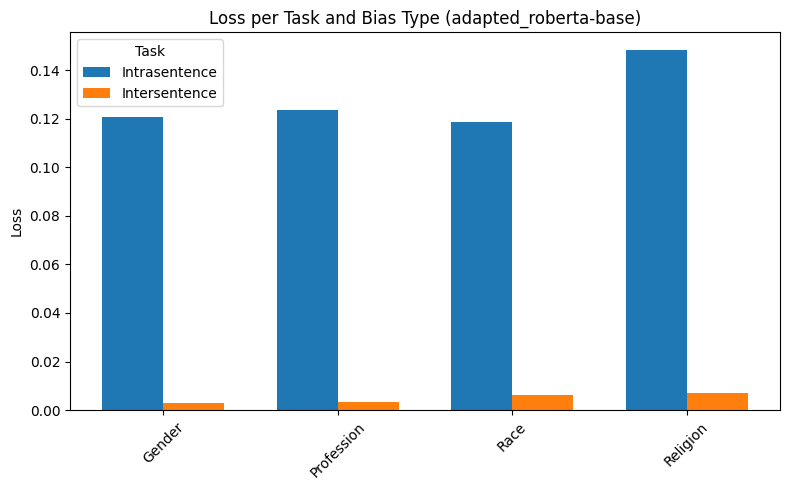

<Figure size 640x480 with 0 Axes>

In [93]:
#visualize loss per bias target and task types
intra_loss = [intra[bias]["Loss"] for bias in bias_types]
inter_loss = [inter[bias]["Loss"] for bias in bias_types]

plot_loss_scores(intra_loss, inter_loss, mlm_model.model_name)

### Sentiment Measurement Plot (after applying bias mitigation)

In [37]:
adapted_model_name = f"adapted_{pretrained_model_name}"

In [44]:
# !pip install spacy textblob
# !python -m textblob.download_corpora
# !python -m spacy download en_core_web_sm

print(f'Overall sentiment results for ({mlm_model.model_name}):')
sentiment_evaluator = SentimentEvaluator(
    gold_file_path=INPUT_FILE, predictions=results)
overall = sentiment_evaluator.get_overall_results()
sentiment_evaluator.pretty_print(overall['overall'])

if os.path.exists(SENTIMENT_RESULTS_FILE):
    with open(SENTIMENT_RESULTS_FILE, "r") as f:
        print("Loading already existing sentiment results file...")
        d = json.load(f)
else:
    d = {}

#assuming that the file follows a format of {MODELNAME}_predictions.json"
predictions_filename = os.path.basename(output_file)
if "_predictions" in predictions_filename:
    pretrained_class = predictions_filename.replace("_predictions.json", "")
    d[pretrained_class] = overall
else:
    d = overall

print(f"Saving sentiment results to {SENTIMENT_RESULTS_FILE}...")
with open(SENTIMENT_RESULTS_FILE, "w+") as f:
    json.dump(d, f, indent=2)


Overall sentiment results for (adapted_roberta-base):
Count: 639.0
Positive Score: 0.30672926447574334
Negative Score: 0.2237871674491393
Neutral Score: 0.4694835680751174
Loading already existing sentiment results file...
Saving sentiment results to sentiment_results.json...


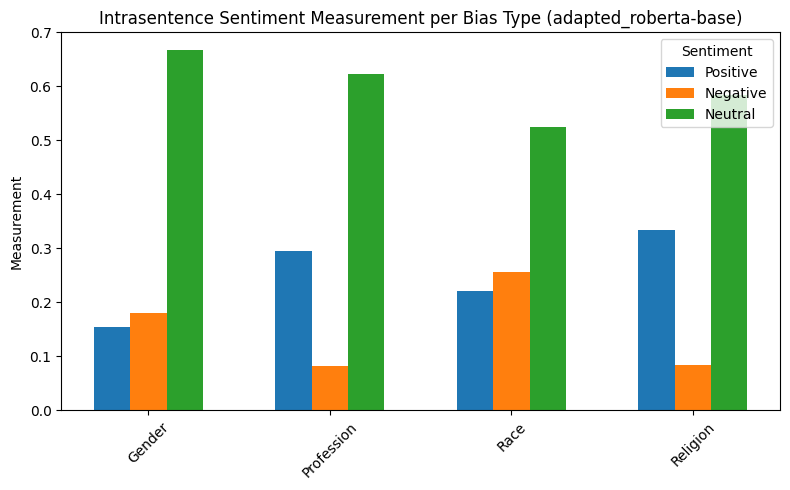

<Figure size 640x480 with 0 Axes>

In [45]:
adapted_model_sent_intrasentence = {bias: {measure : d[adapted_model_name]["intrasentence"][bias][measure] for measure in measurements} for bias in bias_types}
bias_sent_measurements = {measure: [adapted_model_sent_intrasentence[bias][measure] for bias in bias_types] for measure in measurements}
plot_sentiment_measurements(bias_sent_measurements, adapted_model_name, "Intrasentence")

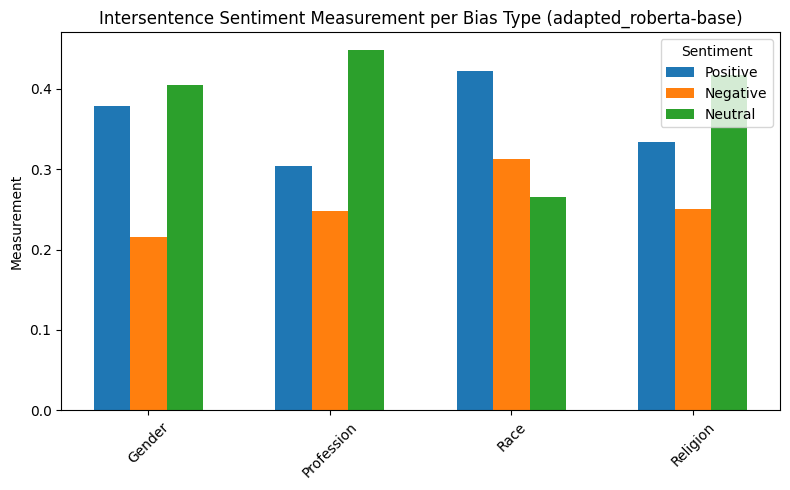

<Figure size 640x480 with 0 Axes>

In [71]:
adapted_model_sent_intersentence = {bias: {measure : d[adapted_model_name]["intersentence"][bias][measure] for measure in measurements} for bias in bias_types}
bias_sent_measurements = {measure: [adapted_model_sent_intersentence[bias][measure] for bias in bias_types] for measure in measurements}
plot_sentiment_measurements(bias_sent_measurements, adapted_model_name, "Intersentence")

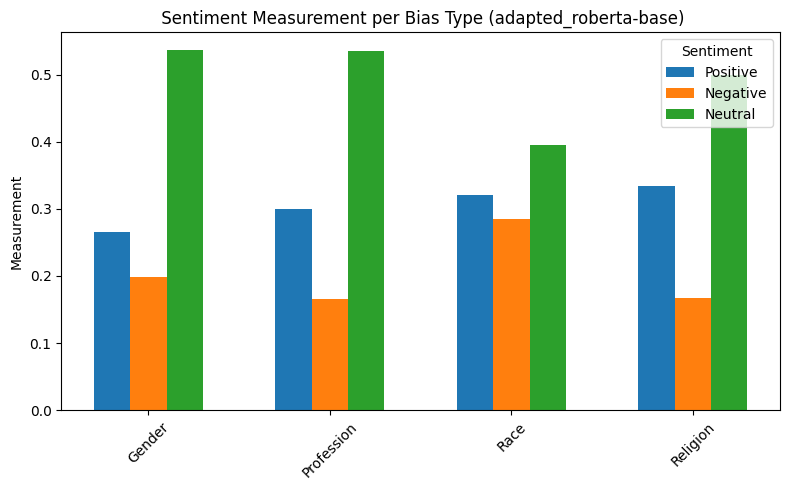

<Figure size 640x480 with 0 Axes>

In [47]:
adapted_model_sent_overall = {bias: {measure : (d[adapted_model_name]["intrasentence"][bias][measure] + d[adapted_model_name]["intersentence"][bias][measure])/2 for measure in measurements} for bias in bias_types}
bias_sent_measurements = {measure: [adapted_model_sent_overall[bias][measure] for bias in bias_types] for measure in measurements}
plot_sentiment_measurements(bias_sent_measurements, adapted_model_name)

### Overall Comparison between Perfomances (before and after adaptation)

Loading already existing results file...


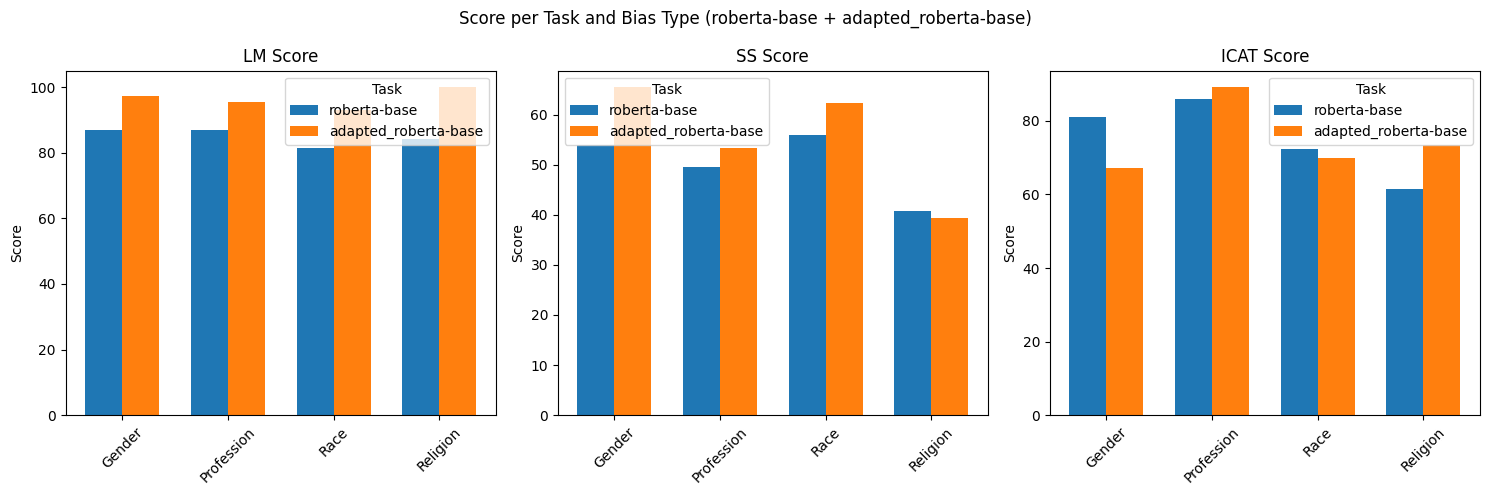

<Figure size 640x480 with 0 Axes>

In [94]:
#load existing results of any model
if os.path.exists(RESULTS_FILE):
    with open(RESULTS_FILE, "r") as f:
        print("Loading already existing results file...")
        d = json.load(f)
else:
    d = {}

base_model_overall = {bias: {metric : (d[pretrained_model_name]["intrasentence"][bias][metric] + d[pretrained_model_name]["intersentence"][bias][metric])/2 for metric in metrics} for bias in bias_types}
adapted_model_overall = {bias: {metric : (d[adapted_model_name]["intrasentence"][bias][metric] + d[adapted_model_name]["intersentence"][bias][metric])/2 for metric in metrics} for bias in bias_types}

#visualize scores per bias target and task types
base_model_data = {metric: [base_model_overall[bias][metric] for bias in bias_types] for metric in metrics}
adapted_model_data = {metric: [adapted_model_overall[bias][metric] for bias in bias_types] for metric in metrics}

plot_score_records(base_model_data, adapted_model_data, f"{pretrained_model_name} + {adapted_model_name}", pretrained_model_name, adapted_model_name)

### Observations on Score Comparison
We can notice that the LM score for the adapted model is higher than the base model, which is a sign of a better language comprehension after adaptation. But in the other hand, the SS score has significantly increased for the adapted model (in case of gender and race bias domains) w.r.t. the base model, reducing the ICAT score for these bias domains for the adapted model.  
In **sec.7.0** of the original paper, The relationship between the LM and SS scores is well-explained that "All models exhibit a strong correlation between lms and ss (Spearman rank correlation ρ of 0.87). As the language model becomes stronger, its stereotypical bias (ss) does too". 
The correlation between lms and ss is unfortunate and perhaps unavoidable as long as we rely on the real world distribution of corpora to train language models since these corpora are likely to reflect stereotypes (which could be positive or negative stereotype as well as the negative bias that could be present in case of anti-stereotyical sentences). So in order to enhance the LM score, we can't avoid the increase of the SS score!  
We might prefer having a higher anti-stereotype score over stereotype score (which doesn't guarantee the neutrality of the model); by give a higher label values for anti-stereotypical sentences (ex. 0.6 for anti-stereotype and 0.4 for steretype in order to favor some of positivity over negativity), but we should take into account that the LM score would decrease.

However, remains the idea of the ***IdealLM*** which maximizes the neutrality between both stereotypical and anti-stereotypical sentences. The neutrality can be considered as a qualitative index for evaluation.

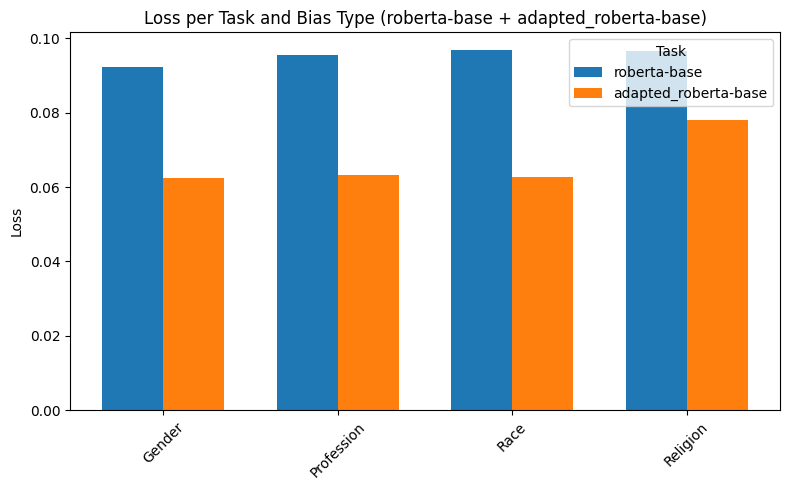

<Figure size 640x480 with 0 Axes>

In [73]:
#visualize loss per bias target and task types
base_model_loss = [(d[pretrained_model_name]["intrasentence"][bias]["Loss"] + d[pretrained_model_name]["intersentence"][bias]["Loss"])/2 for bias in bias_types]
adapted_model_loss = [(d[adapted_model_name]["intrasentence"][bias]["Loss"] + d[adapted_model_name]["intersentence"][bias]["Loss"])/2 for bias in bias_types]

plot_loss_scores(base_model_loss, adapted_model_loss, f"{pretrained_model_name} + {adapted_model_name}", pretrained_model_name, adapted_model_name)

### Observations on Loss Comparison
We can creally notice that the loss is significantly reduced after training the bias-domains'sentence on equal labels. The reduction in the loss for all bias domains after model adaptation shows that the model confidence in stereotypical/anti-stereotypical sentences has became close to 0.50 implying reaching a sort of equality in stereotypical/anti-stereotypical associations with the main context, which is a required property of the ***IdealizedLM***